In [38]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import seaborn
import statistics
import sys, time
import collections
import itertools
from scipy.fft import fft, fftfreq
from scipy import signal
from scipy.stats import mode, kurtosis, norm
from scipy.spatial.distance import squareform
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [39]:
# Load the Excel file into a DataFrame
file_path = os.path.join("data", "Preprocessed_AFData.xlsx")
df = pd.read_excel(file_path)

# Print the first 10 rows of the DataFrame
df.head(10)


,data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,...,data22,data23,data24,data25,data26,data27,data28,data29,data30,Control
0,0.0,0.000000,0.000000,0.100000,-0.100000,0.000000,0.000000,0.400000,0.100000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,-0.400000,-0.600000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.954545,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.078947,-0.078947,0.210526,-0.131579,0.921053,-0.815789,-0.184211,0.000000,0.052632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.871795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


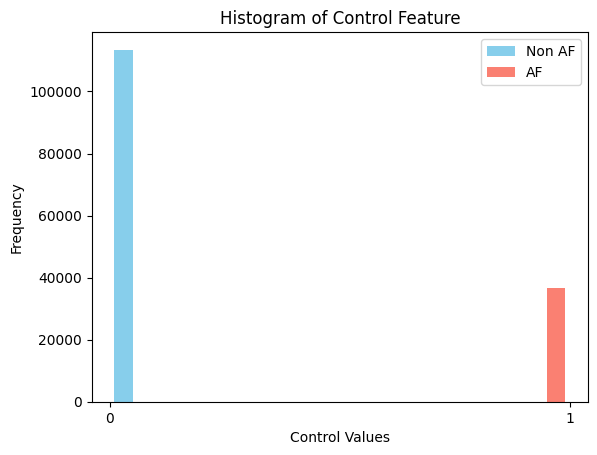

((113463, 31), (36537, 31))

In [40]:
# Separate the data into two groups based on the "Control" values
non_af = df[df['Control'] == 0]
af = df[df['Control'] == 1]

# Plot histograms for each group
plt.hist([non_af['Control'], af['Control']], bins=10, color=['skyblue', 'salmon'], label=['Non AF', 'AF'])

plt.xticks([0, 1], ['0', '1'])
# Add labels and title
plt.xlabel('Control Values')
plt.ylabel('Frequency')
plt.title('Histogram of Control Feature')

# Add legend
plt.legend()

# Show plot
plt.show()
non_af.shape,af.shape

The new data is created by undersampled to be the same size as "af" rows which is 36537. Then two undersampled data concatinated and shuffled.

In [41]:
# Step 1: Identify indices of majority class samples (0 values)
majority_indices = df[df['Control'] == 0].index
minority_indices = df[df['Control'] == 1]
# Step 2: Randomly select subset of indices
undersampled_indices = np.random.choice(majority_indices, size=36537, replace=False)

# Step 3: Create new DataFrame with undersampled majority class
undersampled_data = df.loc[undersampled_indices]
new_data = pd.concat([undersampled_data, minority_indices],ignore_index=True)
new_data = new_data.sample(frac=1).reset_index(drop=True)
new_data.head(30)
new_data.shape

(73074, 31)

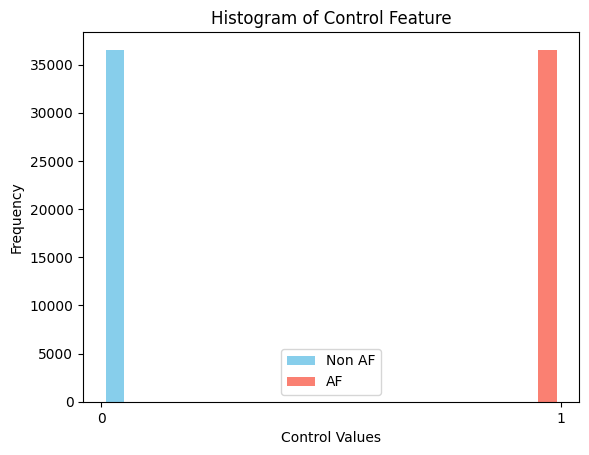

((36537, 31), (36537, 31))

In [42]:
# Separate the data into two groups based on the "Control" values
non_af = new_data[new_data['Control'] == 0]
af = new_data[new_data['Control'] == 1]

# Plot histograms for each group
plt.hist([non_af['Control'], af['Control']], bins=10, color=['skyblue', 'salmon'], label=['Non AF', 'AF'])

plt.xticks([0, 1], ['0', '1'])
# Add labels and title
plt.xlabel('Control Values')
plt.ylabel('Frequency')
plt.title('Histogram of Control Feature')

# Add legend
plt.legend()

# Show plot
plt.show()
non_af.shape,af.shape

Logistic Regression

In [43]:
X = new_data.drop(columns=['Control'])
y = new_data['Control'].astype(str)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize the logistic regression model
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7305
           1       0.96      0.90      0.93      7310

    accuracy                           0.93     14615
   macro avg       0.93      0.93      0.93     14615
weighted avg       0.93      0.93      0.93     14615



Decision Tree

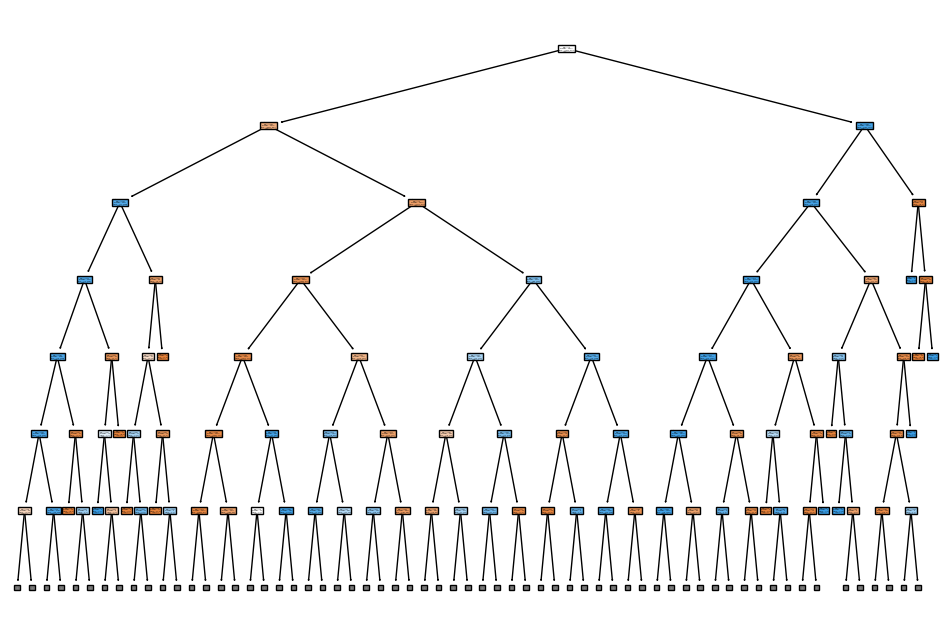

In [44]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
tree_model = DecisionTreeClassifier()

tree_model.fit(X_train, y_train)
feature_namesl = list(X.columns.values)
classes = list(tree_model.classes_)
plt.figure(figsize=(12, 8))
plot_tree(tree_model, feature_names=feature_namesl, class_names=classes, filled=True,max_depth=6)
plt.show()


Naive Bayes

In [45]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7899418405747519


Support Vector Machine Model

In [46]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_classifier = SVC(kernel='linear')  # You can choose different kernels (e.g., 'linear', 'rbf', 'poly')
svm_classifier.fit(X_train, y_train)

# Predict the labels for the new data
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of linear kernel:", accuracy)

svm_classifier2 = SVC(kernel='rbf')  # You can choose different kernels (e.g., 'linear', 'rbf', 'poly')
svm_classifier2.fit(X_train, y_train)

# Predict the labels for the new data
y_pred2 = svm_classifier2.predict(X_test)

# Evaluate the model
accuracy2 = accuracy_score(y_test, y_pred2)
print("Accuracy of rbf kernel:", accuracy2)


svm_classifier3 = SVC(kernel='poly')  # You can choose different kernels (e.g., 'linear', 'rbf', 'poly')
svm_classifier3.fit(X_train, y_train)

# Predict the labels for the new data
y_pred3 = svm_classifier3.predict(X_test)

# Evaluate the model
accuracy3 = accuracy_score(y_test, y_pred3)
print("Accuracy of poly kernel:", accuracy3)

Accuracy of linear kernel: 0.9326719124187479
Accuracy of rbf kernel: 0.9530619226821758
Accuracy of poly kernel: 0.9506671228190215


Cross Validation to Compare Models 

In [47]:
from sklearn.model_selection import cross_val_score

logistic_scores = cross_val_score(logreg, X, y, cv=5, scoring='accuracy')
print("Logistic Regression Accuracy: %0.2f (+/- %0.2f)" % (logistic_scores.mean(), logistic_scores.std() * 2))

tree_scores = cross_val_score(tree_model, X, y, cv=5, scoring='accuracy')
print("Decision Tree Accuracy: %0.2f (+/- %0.2f)" % (tree_scores.mean(), tree_scores.std() * 2))

nb_classifier = cross_val_score(nb_classifier, X, y, cv=5, scoring='accuracy')
print("Naive Bayes Accuracy: %0.2f (+/- %0.2f)" % (nb_classifier.mean(), nb_classifier.std() * 2))

svm_classifier2 = cross_val_score(svm_classifier2, X, y, cv=5, scoring='accuracy')
print("Support Vector Machine Accuracy: %0.2f (+/- %0.2f)" % (svm_classifier2.mean(), svm_classifier2.std() * 2))

c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

Logistic Regression Accuracy: 0.93 (+/- 0.00)
Decision Tree Accuracy: 0.93 (+/- 0.00)
Naive Bayes Accuracy: 0.78 (+/- 0.02)
Support Vector Machine Accuracy: 0.95 (+/- 0.00)
